# Model the uncertainty in o2sat measurements

Create a lookup table that links the possible real O2Sat values for the measured and rounded values that we put into the model. For that generate a number in a range 90-100, 1) add gaussian noise, 2) round it, 3) keep that number if the result is 98. Do this many times to get the input distribution values that map to 98. Take the std of that distribution.

In [107]:
import numpy as np
import src.data.breathe_data as breathe_data
import src.data.helpers as datah
import plotly.express as px
import plotly.figure_factory as ff

In [65]:
df = breathe_data.build_O2_FEV1_df()


*** Building O2 Saturation and FEV1 dataframe ***

*** Loading patients data ***
Warning - 4 NaN values in dataframe
The 4 NaN values belong to IDs ('322', '338', '344', '348') whose height are missing.
However, we don't correct for them as we don't have any measurement corresponding to those IDs for now.
Loaded 258 individuals

*** Loading measurements data ***
Dropping 1 entries with FEV1 = 6.0 for ID 330
* Checking for same day measurements *
* Checking for same day measurements *
Number of IDs:  233
Number of rows:  26812
Number of FEV1 recordings: 23778
Number of O2 Saturation recordings: 23431
Dropped 0 entries with NaN O2 Saturation and NaN FEV1
Dropped 3381 entries with NaN O2 Saturation
Dropped 3034 entries with NaN FEV1
20397 entries remain
Warning for ID 202: FEV1 % Predicted should be in 0-140%, got 147.24696075623552
Warning for ID 202: FEV1 % Predicted should be in 0-140%, got 147.24696075623552
Warning for ID 202: FEV1 % Predicted should be in 0-140%, got 149.5053497248

IDs: 213
Healthy IDs: 213
IDs with less than 10 measurements: 42
Remaining IDs: 54


<Axes: >

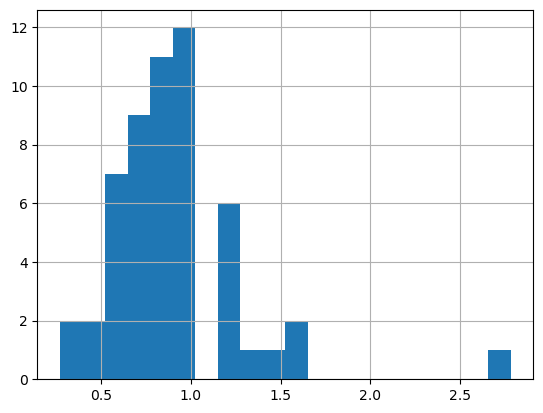

In [67]:
# Estimate the uncertainty of an o2 sat measurement
# Take the healthiest individuals and compute the standard deviation of their measurements


def get_std(df):
    """
    If there are more than 10 values, compute the standard deviation
    Else, return NaN
    """
    if len(df) > 10:
        return df.std()
    else:
        return np.nan


df_std = datah.compute_avg(df, "FEV1 % Predicted", "%")
print(f"IDs: {df.ID.nunique()}")
# Filter healthy individuals
df_std = df_std[df_std["FEV1 % Predicted"] > 80]
print(f"Healthy IDs: {df.ID.nunique()}")

stds = df_std.groupby("ID")["O2 Saturation"].agg(get_std)
print(f"IDs with less than 10 measurements: {stds.isna().sum()}")
stds = stds.dropna()
print(f"Remaining IDs: {len(stds)}")

stds.hist(bins=20)

In [79]:
# Randomly generate a number in the range 90.0-100.0
x = np.random.uniform(90.0, 100.0)
print(x)
# Add gaussian noise to the number with a standard deviation of 1.09
x = np.random.normal(x, 1)
print(x)
# Round x to the nearest 0.5
x = round(x * 2) / 2
print(x)

91.5152031971934
91.6613769953798
91.5


In [114]:
def generate_o2sat_measurement():
    # Randomly generate a number in the range 90.0-100.0
    real = np.random.uniform(90.0, 100.0)
    # Add gaussian noise to the number with a standard deviation of 1.09
    measured = np.random.normal(real, 1)
    # Round x to the nearest 0.5
    rounded = round(measured * 2) / 2
    return real, measured, rounded


def lookup_real_value(ref=98.0):
    # Repeat 1000 times
    real_arr = np.array([])
    for i in range(1000000):
        # Generate a measurement
        real, measured, rounded = generate_o2sat_measurement()
        # print(real, measured, rounded)
        if rounded == ref:
            real_arr = np.append(real_arr, real)
    # Print the std
    print(f"Std of values giving {ref}: {round(real_arr.std(), 3)}")

    # Plot the distribution of the real values with plotly
    fig = ff.create_distplot(
        [real_arr], ["Real Values"], bin_size=0.1, show_rug=False, show_hist=True
    )
    # fig = px.histogram(real_arr, nbins=100)
    # reduce width
    fig.update_layout(
        width=800,
        title=f"Real O2 sat values giving {str(ref)} after gaussian + rounding noise",
    )
    fig.show()
    return -1


lookup_real_value(96.0)
lookup_real_value(98.0)
lookup_real_value(99.0)

Std of values giving 96.0: 1.01


Std of values giving 98.0: 0.948


Std of values giving 99.0: 0.797


-1